<a href="https://colab.research.google.com/github/jxb5778/topic_modeling/blob/master/VAE_Topic_Model_20_News_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from sklearn.datasets import fetch_20newsgroups


data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)

In [3]:
print(len(data))

11314


In [4]:
print(data[3])

Notwithstanding all the legitimate fuss about this proposal, how much
of a change is it?  ATT's last product in this area (a) was priced over
$1000, as I suspect 'clipper' phones will be; (b) came to the customer 
with the key automatically preregistered with government authorities. Thus,
aside from attempting to further legitimize and solidify the fed's posture,
Clipper seems to be "more of the same", rather than a new direction.
   Yes, technology will eventually drive the cost down and thereby promote
more widespread use- but at present, the man on the street is not going
to purchase a $1000 crypto telephone, especially when the guy on the other
end probably doesn't have one anyway.  Am I missing something?
   The real question is what the gov will do in a year or two when air-
tight voice privacy on a phone line is as close as your nearest pc.  That
has got to a problematic scenario for them, even if the extent of usage
never surpasses the 'underground' stature of PGP.


In [5]:
import nltk
from nltk import word_tokenize       
from nltk.corpus import stopwords   
from nltk.stem import WordNetLemmatizer 

import re

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
class LemmaTokenizer(object):
    def __init__(self, token_pattern=r"(?u)\b\w\w+\b", stop='english'):
        self.wnl = WordNetLemmatizer()
        self.token_pattern = re.compile(token_pattern)
        self.stop = set(stopwords.words('english'))
        
    def __call__(self, doc):
        return [
                self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if len(t) > 2 
                and re.match("[a-z].*",t) 
                and re.match(self.token_pattern, t) 
                and t not in self.stop
                ]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vocab_size = 15000

tokenizer = LemmaTokenizer()

vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=LemmaTokenizer(),
                             max_features=vocab_size,
                             max_df=0.95, 
                             min_df=5)

vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()

vectors = vectors.toarray()

print('vocab size:', len(vocab_list))


vocab size: 13538


In [9]:
if vocab_size > len(vocab_list):
  vocab_size = len(vocab_list)
vocab_size

13538

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
latent_dim = 20
batch_size=200
input_shape = (batch_size, vocab_size)

initializer = tf.keras.initializers.GlorotNormal()

encoder_inputs = keras.Input(batch_shape=input_shape)

h = layers.Dense(500, activation="relu", kernel_initializer=initializer)(encoder_inputs)
h = layers.Dense(500, activation="relu")(h)
h = layers.Dense(500, activation="relu")(h)

z_mean = layers.BatchNormalization()(layers.Dense(latent_dim, name="z_mean")(h))
z_log_var = layers.BatchNormalization()(layers.Dense(latent_dim, name="z_log_var")(h))
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(200, 13538)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (200, 500)           6769500     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (200, 500)           250500      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (200, 500)           250500      dense_1[0][0]                    
____________________________________________________________________________________________

In [12]:
initializer_decode = tf.keras.initializers.GlorotNormal()

latent_inputs = keras.Input(shape=(latent_dim,))

"""
h_decode = layers.Dense(128, activation="softmax", kernel_initializer=initializer_decode)(latent_inputs)
h_decode = layers.BatchNormalization()(h_decode)
h_decode = layers.Dropout(0.5)(h_decode)

h_decode = layers.Dense(256, activation="softmax", kernel_initializer=initializer_decode)(h_decode)
h_decode = layers.BatchNormalization()(h_decode)
h_decode = layers.Dropout(0.5)(h_decode)


h_decode = layers.Dense(512, activation="softmax", kernel_initializer=initializer_decode)(h_decode)
h_decode = layers.BatchNormalization()(h_decode)
"""

decoder_outputs = layers.Dense(vocab_size)(latent_inputs)
decoder_outputs = layers.BatchNormalization()(decoder_outputs)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 13538)             284298    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13538)             54152     
Total params: 338,450
Trainable params: 311,374
Non-trainable params: 27,076
_________________________________________________________________


In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1, gamma=0.2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.gamma = gamma

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            data = tf.dtypes.cast(data, tf.float32)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )

            reconstruction_loss *= data.shape[1]

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -self.beta
            kl_loss = tf.math.maximum(self.gamma, kl_loss)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
vae = VAE(encoder, decoder, beta=5, gamma=0.5)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002))

In [15]:
vectors = vectors[:11200]

In [16]:
len(vectors)

11200

In [17]:
history = vae.fit(vectors, verbose=1, batch_size=batch_size, epochs=25)

Epoch 1/25
56/56 [==============================] - 13s 231ms/step - loss: 931.8960 - reconstruction_loss: 930.6974 - kl_loss: 1.1986
Epoch 2/25
56/56 [==============================] - 13s 235ms/step - loss: 706.3354 - reconstruction_loss: 700.4828 - kl_loss: 5.8526
Epoch 3/25
56/56 [==============================] - 13s 233ms/step - loss: 586.4998 - reconstruction_loss: 574.9518 - kl_loss: 11.5480
Epoch 4/25
56/56 [==============================] - 13s 233ms/step - loss: 547.1743 - reconstruction_loss: 532.7791 - kl_loss: 14.3952
Epoch 5/25
56/56 [==============================] - 15s 268ms/step - loss: 531.1250 - reconstruction_loss: 515.4006 - kl_loss: 15.7244
Epoch 6/25
56/56 [==============================] - 15s 268ms/step - loss: 517.3829 - reconstruction_loss: 501.0886 - kl_loss: 16.2943
Epoch 7/25
56/56 [==============================] - 13s 233ms/step - loss: 508.9020 - reconstruction_loss: 492.3878 - kl_loss: 16.5142
Epoch 8/25
56/56 [==============================] - 13s 2

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])


<Figure size 432x288 with 0 Axes>

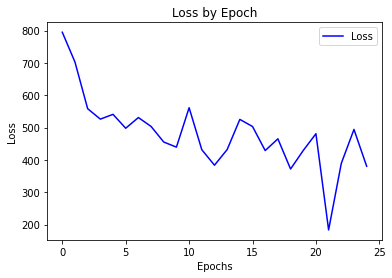

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

print(history.history.keys())

zoom = 0
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[zoom:], loss[zoom:], 'b')

plt.title('Loss by Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
for weight in vae.get_weights():
  print(weight.shape)

(13538, 500)
(500,)
(500, 500)
(500,)
(500, 500)
(500,)
(500, 20)
(20,)
(500, 20)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20, 13538)
(13538,)
(13538,)
(13538,)
(13538,)
(13538,)


In [20]:
weights = vae.get_weights()[-6]

"""
weights = np.dot(weights, vae.get_weights()[-18])
weights = np.dot(weights, vae.get_weights()[-12])
weights = np.dot(weights, vae.get_weights()[-6])
"""

print(weights.shape)

(20, 13538)


In [21]:
exp_beta = np.exp(weights).T
phi = (exp_beta/np.sum(exp_beta, axis=0)).T

In [22]:
for k, phi_k in enumerate(phi):
    print('topic: {}'.format(k))
    for w in np.argsort(phi_k)[::-1][:10]:
        print(vocab_list[w], phi_k[w])
    print()

topic: 0
helsinki 7.600199e-05
igor 7.5918375e-05
israel 7.571057e-05
obo 7.545522e-05
went 7.535477e-05
bulgaria 7.535242e-05
liberty 7.532163e-05
standing 7.53194e-05
father 7.53139e-05
whereas 7.529494e-05

topic: 1
may 7.786995e-05
also 7.769661e-05
could 7.767378e-05
would 7.696069e-05
see 7.689608e-05
key 7.6894e-05
people 7.686298e-05
way 7.685604e-05
another 7.662532e-05
make 7.648863e-05

topic: 2
forget 7.664487e-05
scorer 7.642556e-05
francis 7.590154e-05
drake 7.582255e-05
robitaille 7.577089e-05
janney 7.575652e-05
nylander 7.5695534e-05
oates 7.558028e-05
randy 7.549313e-05
cease 7.543629e-05

topic: 3
law 7.693227e-05
jew 7.6356424e-05
country 7.600509e-05
fact 7.592631e-05
question 7.5861135e-05
budget 7.585523e-05
shall 7.5779324e-05
way 7.575836e-05
lord 7.5727185e-05
american 7.5709824e-05

topic: 4
forgiveness 7.657767e-05
ceremonial 7.58676e-05
faith 7.569907e-05
ephesian 7.55884e-05
blatant 7.555683e-05
astray 7.554466e-05
b4q 7.550739e-05
shook 7.5456854e-05
evil

In [23]:
!pip install tmtoolkit

     |████████████████████████████████| 7.2MB 2.5MB/s 
     |████████████████████████████████| 14.5MB 308kB/s 
     |████████████████████████████████| 10.0MB 44.1MB/s 
     |████████████████████████████████| 10.5MB 32.5MB/s 
     |████████████████████████████████| 11.6MB 35.7MB/s 
     |████████████████████████████████| 112kB 34.0MB/s 
     |████████████████████████████████| 25.9MB 152kB/s 
     |████████████████████████████████| 2.1MB 38.8MB/s 
  Created wheel for globre: filename=globre-0.1.5-cp36-none-any.whl size=19528 sha256=3d9b8bc34e17b3b4d3c3b2a3833e74055907f33546942fb83ce14597015a0ea0
  Stored in directory: /root/.cache/pip/wheels/c4/3f/7f/be546f6d880521a8a7a1fe84cbe135fa859be63084682d3292
Successfully built globre
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pand

In [24]:
from tmtoolkit import topicmod


# Calculate UMASS coherence score as defined by (Mimno 2011).

coherence = topicmod.evaluate.metric_coherence_mimno_2011(phi, vectors, top_n=20, eps=1e-12, normalize=True, return_mean=False)
print("Coherence by topic: ", coherence)
print("Coherence: ", np.mean(coherence))

Coherence by topic:  [-14.2779206   -1.75880267 -16.49846422  -4.81952884 -18.33667504
 -12.73147221  -3.46437632 -16.68509193  -7.87911453  -2.28601698
 -23.53182793  -1.60192519  -3.33722425  -1.64200569 -18.67780164
  -2.20700254  -2.45554101 -24.44533781  -7.43870182  -2.34888833]
Coherence:  -9.32118597604522


In [25]:
z_mean, z_mu, z = encoder.predict(vectors, batch_size=batch_size)

In [26]:
z_mean

array([[-0.19246793,  1.065398  , -0.3214648 , ..., -0.25904262,
        -0.06494384,  0.21661784],
       [-0.24921551,  0.84740376, -0.4225087 , ..., -0.38684472,
         0.08311541,  0.15676424],
       [-0.31843805,  1.4354327 , -0.7398439 , ..., -0.677972  ,
         0.10980493,  0.21762723],
       ...,
       [-0.05478524,  1.0569564 , -0.39921552, ..., -0.1653213 ,
         0.02717871,  0.32597467],
       [-0.41675788,  1.7126312 , -0.9348275 , ..., -0.84657896,
        -0.46595284,  0.38722202],
       [-0.2811031 ,  0.62504214, -0.33142897, ..., -0.29535535,
        -0.04631453,  0.15215454]], dtype=float32)

In [27]:
doc_exp_beta = np.exp(z_mean).T
doc_phi = (doc_exp_beta/np.sum(doc_exp_beta, axis=0)).T

In [28]:
doc_phi

array([[0.03259136, 0.11465333, 0.02864704, ..., 0.03049225, 0.03702418,
        0.04906436],
       [0.03293271, 0.09860144, 0.02769283, ..., 0.02869828, 0.04591526,
        0.0494245 ],
       [0.02365435, 0.13664927, 0.01552018, ..., 0.01651077, 0.03629899,
        0.04043161],
       ...,
       [0.03888448, 0.11819512, 0.02755447, ..., 0.03481537, 0.04220586,
        0.0569034 ],
       [0.0198732 , 0.16712822, 0.01183786, ..., 0.01293001, 0.0189192 ,
        0.044405  ],
       [0.03465547, 0.08576413, 0.03295456, ..., 0.03416505, 0.04382674,
        0.05344822]], dtype=float32)

In [49]:
doc_lengths = vectors.sum(axis=1)

In [48]:
doc_lengths

array([62, 45, 60, ..., 45, 77, 11])

In [50]:
term_freq_list = vectors.sum(axis=0)

In [39]:
term_freq_list

array([909,  39,  46, ...,   5,   9,   8])

In [33]:
np.median(term_freq_list)

17.0

In [34]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 14.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ead855bfaa8ab994ba108812c379045bfff80083de37561682357f220e0b6d11
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=b6a493109ba7c5c5cd29c6f8199cf38ff030ffde139346a0865c0cf7914dd376
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [59]:
import pyLDAvis


pyLDAvis.enable_notebook()

vis = pyLDAvis.prepare(
    topic_term_dists=phi,
    doc_topic_dists=doc_phi,
    doc_lengths=doc_lengths,
    vocab=vocab_list,
    term_frequency=term_freq_list,
)

vis

KeyError: ignored

In [ ]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.000101  0.000025       1        1  14.946173
4     -0.000030  0.000020       2        1  10.396923
14    -0.000075  0.000013       3        1   8.310774
12    -0.000026 -0.000029       4        1   8.054803
17    -0.000055  0.000017       5        1   7.614554
2     -0.000010 -0.000002       6        1   5.523376
18    -0.000038  0.000019       7        1   4.687168
6      0.000028  0.000023       8        1   4.604247
0     -0.000008 -0.000003       9        1   4.232394
3      0.000028 -0.000055      10        1   4.087117
15    -0.000054 -0.000064      11        1   3.841104
7      0.000054 -0.000012      12        1   3.699326
1     -0.000065 -0.000018      13        1   3.322679
16     0.000016  0.000001      14        1   3.116371
19     0.000040  0.000004      15        1   2.673402
5      0.000059 -0.000018      16        1   2.500019
13     0.000021  0.000021      17        1   2.463063
9      0.000104  0.000019      18        1   2.314919
8      0.000112  0.000003      19        1   2.073627
11    -0.000001  0.000038      20        1   1.537964, topic_info=           Term       Freq      Total Category  logprob  loglift
11974      team  70.000000  70.000000  Default  30.0000  30.0000
9010     player  68.000000  68.000000  Default  29.0000  29.0000
8951        pit  68.000000  68.000000  Default  28.0000  28.0000
13312      wong  68.000000  68.000000  Default  27.0000  27.0000
5955        inc  68.000000  68.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
740         art   1.162453  70.789970  Topic20  -9.4167   0.0655
12239     titan   1.155092  70.179947  Topic20  -9.4230   0.0678
11974      team   1.157487  70.874733  Topic20  -9.4209   0.0600
10678    season   1.151195  69.425613  Topic20  -9.4264   0.0753
10862  shanahan   1.151353  69.813866  Topic20  -9.4262   0.0698

[844 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.147890      a86
0          2  0.103523      a86
0          3  0.088734      a86
0          4  0.073945      a86
0          5  0.073945      a86
...      ...       ...      ...
13525     16  0.029303  zhamnov
13525     17  0.029303  zhamnov
13525     18  0.029303  zhamnov
13525     19  0.029303  zhamnov
13525     20  0.014652  zhamnov

[11020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 15, 13, 18, 3, 19, 7, 1, 4, 16, 8, 2, 17, 20, 6, 14, 10, 9, 12])